# Deep Learning with PyTorch: A 60 Minute Blitz

This is me following along to the [tutorial from the official PyTorch website](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py). Note that I'm also taking some asides and detours as I type the code to investigate interesting detours as I seek to more fully understand the runtime.

The first thing that we need to do is import the torch library. This takes a fair amount of time. Fortunately, this is a one-time operation per session.

In [1]:
import torch

This Hello, World example initializes a new tensor of dimensions `[5,3]` that contain random values from whatever the memory was before the call, i.e., it does not zero it out.

In [2]:
x = torch.empty(5, 3)
x

tensor([[1.3563e-19, 1.8888e+31, 8.9066e-15],
        [1.8888e+31, 6.4639e-04, 6.8608e+22],
        [1.7753e+28, 2.0535e-19, 7.5563e+31],
        [1.8014e+25, 8.1335e+32, 7.2436e+22],
        [7.5554e+28, 2.9635e+29, 2.2087e+03]])

This next example constructs a tensor, but this time initialized to zeros:

In [3]:
x = torch.zeros(5, 3)
x

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

You can also specify the _type_ of the zeros that you want, e.g., half precision floating point (which is interesting for its performance characteristics)

In [4]:
x = torch.zeros(5, 3, dtype=torch.half)
x

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float16)

You can also create it with explicit random values:

In [5]:
x = torch.rand(5, 3, dtype=torch.float)
x

tensor([[0.1389, 0.8535, 0.1238],
        [0.6640, 0.5807, 0.8310],
        [0.2637, 0.3751, 0.5752],
        [0.7574, 0.5341, 0.3174],
        [0.6864, 0.0092, 0.2743]])

But if you try and use a type that is only supported on GPUs, e.g., `torch.half`, it will throw an error because `torch.rand` by default will construct the type on the CPU:

In [6]:
x = torch.rand(5, 3, dtype=torch.half)
x

RuntimeError: _th_uniform_ not supported on CPUType for Half

So we solve this by first initializing a `cuda` device:

In [7]:
device = torch.device("cuda")
device

device(type='cuda')

We can pass the `cuda` device as a parameter to `torch.rand` which now constructs the tensor on the GPU successfully. This requires 1 time initialization of the CUDA infrastructure (several seconds), again a per-session cost.

In [11]:
x = torch.rand(5, 3, device=device, dtype=torch.half)
x

tensor([[0.7217, 0.0433, 0.3591],
        [0.3684, 0.6777, 0.0998],
        [0.4692, 0.1526, 0.0967],
        [0.1025, 0.4043, 0.8008],
        [0.8335, 0.7324, 0.1650]], device='cuda:0', dtype=torch.float16)

The size of a tensor is sometimes something that we need to know when debugging. We can do this by using the `size()` member function:

In [12]:
print(x.size())

torch.Size([5, 3])


Tensors support operations such as addition, which does a memberwise addition of all of the elements across tensors of the same size. Let's create a new tensor, y, of the same size with random values:

In [14]:
y = torch.rand(5, 3, device=device, dtype=torch.half)
y

tensor([[0.7612, 0.7363, 0.1208],
        [0.1691, 0.2136, 0.3752],
        [0.9043, 0.7339, 0.3723],
        [0.9688, 0.6328, 0.6787],
        [0.2761, 0.7061, 0.7134]], device='cuda:0', dtype=torch.float16)

We can do an implicit add simply by using the plus operator:

In [15]:
print(x+y)

tensor([[1.4824, 0.7798, 0.4800],
        [0.5376, 0.8916, 0.4751],
        [1.3730, 0.8867, 0.4690],
        [1.0713, 1.0371, 1.4795],
        [1.1094, 1.4385, 0.8784]], device='cuda:0', dtype=torch.float16)


Or we can explicitly use the `torch.add()` function:

In [16]:
print(torch.add(x, y))

tensor([[1.4824, 0.7798, 0.4800],
        [0.5376, 0.8916, 0.4751],
        [1.3730, 0.8867, 0.4690],
        [1.0713, 1.0371, 1.4795],
        [1.1094, 1.4385, 0.8784]], device='cuda:0', dtype=torch.float16)


What happens if the tensor sizes are mismatched? Let's find out:

In [17]:
z = torch.rand(2, 2, device=device, dtype=torch.half)
z

tensor([[0.2134, 0.3101],
        [0.3345, 0.5142]], device='cuda:0', dtype=torch.float16)

As predicted, we get a runtime error when attempting the operation:

In [18]:
print(x+z)

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

In the cases above, we've been adding numbers and producing a new tensor. We can also do in-place addition as well which will replace the value in the tensor for which the `add_()` member is being invoked on:

In [19]:
y.add_(x)
y

tensor([[1.4824, 0.7798, 0.4800],
        [0.5376, 0.8916, 0.4751],
        [1.3730, 0.8867, 0.4690],
        [1.0713, 1.0371, 1.4795],
        [1.1094, 1.4385, 0.8784]], device='cuda:0', dtype=torch.float16)

What happens when we add a scalar to a tensor? Pretty much what you would expect, the scalar gets added to each member of the tensor:

In [20]:
print(y+1)

tensor([[2.4824, 1.7793, 1.4805],
        [1.5371, 1.8916, 1.4746],
        [2.3730, 1.8867, 1.4688],
        [2.0703, 2.0371, 2.4805],
        [2.1094, 2.4375, 1.8789]], device='cuda:0', dtype=torch.float16)


## Tensors and CUDA

Tensors can be moved back and forth between CPU and GPU as well. You can use the `to()` method on the tensor to move a tensor back to the CPU.

In [21]:
cpu_y = y.to("cpu", torch.double)

In [22]:
cpu_y

tensor([[1.4824, 0.7798, 0.4800],
        [0.5376, 0.8916, 0.4751],
        [1.3730, 0.8867, 0.4690],
        [1.0713, 1.0371, 1.4795],
        [1.1094, 1.4385, 0.8784]], dtype=torch.float64)

## Automatic Differentiation

This is the key feature of pytorch (and other deep learning packages) which provides automatic differentiation for all operations on tensors. You can turn on automatic differentiation by setting the `requires_grad=True` on the tensor:

In [23]:
x = torch.ones(2, 2, requires_grad=True)
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [25]:
y = x + 2
y

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)

In [29]:
z = y * 2
z

tensor([[6., 6.],
        [6., 6.]], grad_fn=<MulBackward0>)

RuntimeError: grad can be implicitly created only for scalar outputs

## Neural networks

Let's build a neural network using pytorch by first importing 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Next, let's define a convolutional neural network.

In [2]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [4]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/test1')

In [6]:
import torchvision
import torchvision.transforms as transforms
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


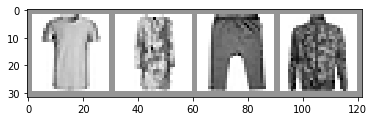

In [10]:
import matplotlib.pyplot as plt

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)